## Initial Investigation

Although it is not a formal question on this assignment, you should begin by reading in the dataset and briefly exploring and summarizing the data, and by adjusting any variables that need cleaning

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

In [3]:
#reading in the data
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
#summary statistics
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(ha.describe())
#variable data types
print(ha.dtypes)
#missing values
print(ha.isnull().sum())

              age         sex          cp      trtbps        chol  \
count  273.000000  273.000000  273.000000  273.000000  273.000000   
mean    54.347985    0.673993    0.974359  132.098901  246.860806   
std      9.163134    0.469611    1.030456   17.700358   52.569726   
min     29.000000    0.000000    0.000000   94.000000  126.000000   
25%     47.000000    0.000000    0.000000  120.000000  211.000000   
50%     56.000000    1.000000    1.000000  130.000000  240.000000   
75%     61.000000    1.000000    2.000000  140.000000  275.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000   

          restecg     thalach      output  
count  273.000000  273.000000  273.000000  
mean     0.538462  149.446886    0.534799  
std      0.528059   23.240707    0.499704  
min      0.000000   71.000000    0.000000  
25%      0.000000  133.000000    0.000000  
50%      1.000000  152.000000    1.000000  
75%      1.000000  166.000000    1.000000  
max      2.000000  202.000

The dataset consists of 273 patient records with no missing values. Key variables include age (ranging from 29 to 77, with a mean of 54.35), chest pain type (cp), and cholesterol levels (chol) which vary widely from 126 to 564 mg/dL. The maximum heart rate achieved (thalach) averages 149.45 bpm, while resting blood pressure (trtbps) has a mean of 132.1 mm Hg. The target variable (output) indicates that 53.48% of patients are at risk of a heart attack. All variables are appropriately stored as integers, ensuring consistency for analysis.

## Part One: Fitting Models

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

- Find the best model based on ROC AUC for predicting the target variable.

- Report the (cross-validated!) ROC AUC metric.

- Fit the final model.

- Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

(Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well. 

In [66]:
# Separate numeric and categorical columns
numeric_columns = ['age', 'trtbps', 'chol', 'thalach']  # Standardize these
categorical_columns = ['sex', 'cp', 'restecg',]  # Dummy encode these

# Standardize the numeric columns
scaler = StandardScaler()
X_numeric = scaler.fit_transform(ha[numeric_columns])

# One-hot encode the categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_categorical = encoder.fit_transform(ha[categorical_columns])

# Combine the numeric and categorical data
X_transformed = np.concatenate([X_numeric, X_categorical], axis=1)

# Get column names for the transformed numeric features and categorical features
num_columns = numeric_columns
cat_columns = encoder.get_feature_names_out(categorical_columns)

# Combine both numeric and categorical columns names
all_columns = np.concatenate([num_columns, cat_columns])

# Convert the combined NumPy array to a DataFrame
X_transformed_df = pd.DataFrame(X_transformed, columns=all_columns)

# Define the target variable
y = ha['output']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.2, random_state=1)

In [67]:

def find_best_model(X_train, X_test, y_train, y_test, model, param_grid, model_name, classes):
    """
    Fits the best model using GridSearchCV (with hyperparameter tuning), evaluates ROC AUC, outputs a confusion matrix,
    and provides a summary of model coefficients or feature importances.
    """
    # Perform hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5)
    grid_search.fit(X_train, y_train)
    
    # Best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Cross-validated ROC AUC
    cv_auc = cross_val_score(best_model, X_train, y_train, scoring='roc_auc', cv=5).mean()
    print(f"{model_name} Cross-Validated ROC AUC: {cv_auc:.2f}")
    print(f"{model_name} Best Parameters: {best_params}")
    
    # Fit the final model and make predictions
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    print(f"{model_name} Confusion Matrix:\n{pd.DataFrame(cm, index=classes, columns=classes)}")
    
    # Model Coefficients or Feature Importances
    if hasattr(best_model, 'coef_'):  # For models like Logistic Regression
        coefficients = best_model.coef_[0]
        feature_importances = pd.Series(coefficients, index=X_train.columns).sort_values(ascending=False)
        print(f"{model_name} Top Coefficients:\n{feature_importances.head(10)}")
    elif hasattr(best_model, 'feature_importances_'):  # For tree-based models
        importances = best_model.feature_importances_
        feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
        print(f"{model_name} Top Feature Importances:\n{feature_importances.head(10)}")
    else:
        print(f"{model_name} does not provide coefficients or feature importances.")
    
    return best_model, best_params

### Q1: KNN

In [68]:
# KNN
knn_model, knn_params = find_best_model(
    X_train, X_test, y_train, y_test,
    KNeighborsClassifier(),
    param_grid={'n_neighbors': range(1, 30), 'weights': ['uniform', 'distance']},
    model_name="KNN",
    classes=[0, 1]
)

KNN Cross-Validated ROC AUC: 0.78
KNN Best Parameters: {'n_neighbors': 22, 'weights': 'distance'}
KNN Confusion Matrix:
    0   1
0  17   7
1  10  21
KNN does not provide coefficients or feature importances.
KNN Cross-Validated ROC AUC: 0.78
KNN Best Parameters: {'n_neighbors': 22, 'weights': 'distance'}
KNN Confusion Matrix:
    0   1
0  17   7
1  10  21
KNN does not provide coefficients or feature importances.


### Q2: Logistic Regression

In [69]:
# Logistic Regression
log_reg_model, log_reg_params = find_best_model(
    X_train, X_test, y_train, y_test,
    LogisticRegression(max_iter=1000, solver='liblinear'),
    param_grid={'C': [0.01, 0.1, 1, 10, 100]},
    model_name="Logistic Regression",
    classes=[0, 1]
)

Logistic Regression Cross-Validated ROC AUC: 0.86
Logistic Regression Best Parameters: {'C': 10}
Logistic Regression Confusion Matrix:
    0   1
0  18   6
1   4  27
Logistic Regression Top Coefficients:
cp_1         2.497107
cp_2         1.947503
cp_3         1.843591
thalach      0.824617
restecg_1    0.069565
age         -0.179601
chol        -0.309562
trtbps      -0.421723
restecg_2   -0.655329
sex_1       -2.256529
dtype: float64
Logistic Regression Cross-Validated ROC AUC: 0.86
Logistic Regression Best Parameters: {'C': 10}
Logistic Regression Confusion Matrix:
    0   1
0  18   6
1   4  27
Logistic Regression Top Coefficients:
cp_1         2.497107
cp_2         1.947503
cp_3         1.843591
thalach      0.824617
restecg_1    0.069565
age         -0.179601
chol        -0.309562
trtbps      -0.421723
restecg_2   -0.655329
sex_1       -2.256529
dtype: float64


### Q3: Decision Tree

In [70]:
tree_model, tree_params = find_best_model(
    X_train, X_test, y_train, y_test,
    DecisionTreeClassifier(),
    param_grid={'max_depth': [None, 5, 10, 20],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [1, 5, 10]},
    model_name="Decision Tree",
    classes=[0, 1]
)

Decision Tree Cross-Validated ROC AUC: 0.74
Decision Tree Best Parameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 20}
Decision Tree Confusion Matrix:
    0   1
0  16   8
1  13  18
Decision Tree Top Feature Importances:
thalach      0.412982
age          0.171467
cp_1         0.126985
cp_2         0.104256
sex_1        0.085949
chol         0.057662
trtbps       0.040699
cp_3         0.000000
restecg_1    0.000000
restecg_2    0.000000
dtype: float64
Decision Tree Cross-Validated ROC AUC: 0.74
Decision Tree Best Parameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 20}
Decision Tree Confusion Matrix:
    0   1
0  16   8
1  13  18
Decision Tree Top Feature Importances:
thalach      0.412982
age          0.171467
cp_1         0.126985
cp_2         0.104256
sex_1        0.085949
chol         0.057662
trtbps       0.040699
cp_3         0.000000
restecg_1    0.000000
restecg_2    0.000000
dtype: float64


### Q4: Interpretation

Which predictors were most important to predicting heart attack risk?

Logistic Regression emphasizes cp (chest pain type) and restecg (resting ECG results). Decision Tree also highlights cp, thalach, and chol (cholesterol).

### Q5: ROC Curve

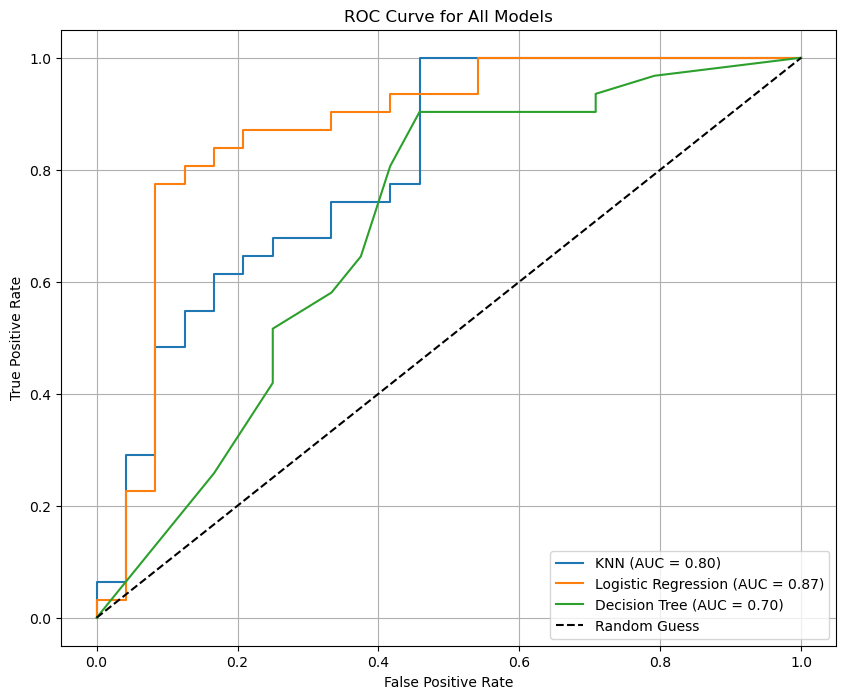

In [71]:
def plot_roc_curve(models, X_test, y_test, model_names):
    plt.figure(figsize=(10, 8))  # Initialize the plot

    for model, model_name in zip(models, model_names):
        # Ensure the model has `predict_proba` to generate ROC curve
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve for the current model
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Plot details for the final ROC plot
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title('ROC Curve for All Models')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Store the models in a list
models = [knn_model, log_reg_model, tree_model]
model_names = ["KNN", "Logistic Regression", "Decision Tree"]

# Plot ROC curves for all models
plot_roc_curve(models, X_test, y_test, model_names)

## Part Two: Metrics

Consider the following metrics:

True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [78]:
def calculate_metrics(TP, TN, FP, FN):
    """
    Calculate Sensitivity, Precision, Specificity, and Cohen's Kappa based on TP, TN, FP, FN.

    Parameters:
    TP (int): True Positives
    TN (int): True Negatives
    FP (int): False Positives
    FN (int): False Negatives

    Returns:
    dict: A dictionary with Sensitivity, Precision, Specificity, and Cohen's Kappa
    """
    # Calculate Sensitivity (Recall)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Calculate Precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0

    # Calculate Specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Calculate Cohen's Kappa
    P_o = (TP + TN) / (TP + TN + FP + FN)  # Observed agreement
    P_e = ((TP + FP) * (TP + FN) + (TN + FP) * (TN + FN)) / (TP + TN + FP + FN) ** 2  # Expected agreement
    kappa = (P_o - P_e) / (1 - P_e) if (1 - P_e) != 0 else 0

    # Return the metrics as a dictionary
    return {
        "Sensitivity": sensitivity,
        "Precision": precision,
        "Specificity": specificity,
        "Cohen's Kappa": kappa
    }


### KNN Model

In [79]:
tp_knn = 21
tn_knn = 17
fp_knn = 10
fn_knn = 7
calculate_metrics(tp_knn, tn_knn, fp_knn, fn_knn)

{'Sensitivity': 0.75,
 'Precision': 0.6774193548387096,
 'Specificity': 0.6296296296296297,
 "Cohen's Kappa": 0.3803843605036448}

### Logistic Regression Model

In [80]:
tp_log = 27
tn_log = 18
fp_log = 4
fn_log = 6
calculate_metrics(tp_log, tn_log, fp_log, fn_log)

{'Sensitivity': 0.8181818181818182,
 'Precision': 0.8709677419354839,
 'Specificity': 0.8181818181818182,
 "Cohen's Kappa": 0.6268656716417912}

### Decision Tree Model

In [81]:
tp_dt = 18
tn_dt = 16
fp_dt = 13
fn_dt = 8
calculate_metrics(tp_dt, tn_dt, fp_dt, fn_dt)

{'Sensitivity': 0.6923076923076923,
 'Precision': 0.5806451612903226,
 'Specificity': 0.5517241379310345,
 "Cohen's Kappa": 0.24162836506894284}

## Part Three: Discussion

Suppose you have been hired by a hospital to create classification models for heart attack risk.

- The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

- Which metric(s) you would use for model selection and why.

- Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

### Q1 
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

Key Concern: The hospital wants to avoid false negatives (when a patient at risk is incorrectly classified as not at risk) because this could lead to lawsuits if a patient who should have been monitored has a heart attack.

Metrics to Use:

Sensitivity (Recall): The hospital would prioritize sensitivity here because sensitivity measures the proportion of true positives (patients at risk for a heart attack) that the model correctly identifies. High sensitivity ensures that most patients at risk are detected, which reduces the risk of false negatives.

Therefore, the model with the highest sensitivity is the Logistic Regression Model.

### Q2
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

Key Concern: The hospital wants to avoid unnecessary hospital admissions and focus only on patients at high risk for heart attacks.

Metrics to Use:

Precision: Here, precision is important because it measures the proportion of predicted positives (patients flagged as at risk) who are actually at risk. The hospital wants to minimize the number of false positives (patients who are incorrectly identified as at risk and are admitted unnecessarily).

The model with the highest precision is the Logistic Regression Model.

### Q3
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

Key Concern: The hospital is more interested in understanding the relationships between different variables (e.g., age, cholesterol, etc.) and heart attack risk, rather than just making predictions.

Metrics to Use:

Feature Importance: In this case, rather than focusing on traditional metrics like sensitivity or precision, the hospital would benefit from looking at feature importances from models like Decision Trees, Random Forests, or Logistic Regression. These models can provide insight into which variables (biological measures) are most important for predicting heart attack risk.

### Q4
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

Key Concern: The hospital is interested in comparing the predictions made by the model with the diagnoses made by the doctors. Here, the goal is to see how well the model agrees with the doctors.

Metrics to Use:

Accuracy: Accuracy would be a useful metric here because it will show how well the model's predictions match the actual diagnoses (both positive and negative).

The model with the highest accuracy would likely be the Logistic Regression Model. 

## Part Four: Validation

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [ ]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

## Part Five: Cohen’s Kappa

Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

Cohen’s Kappa measures the agreement between two raters or classifiers, correcting for chance. It ranges from -1 (perfect disagreement) to 1 (perfect agreement), with 0 indicating no better than random chance. It is particularly useful for imbalanced datasets, as it accounts for class distribution when calculating agreement. When used to evaluate models, Kappa can reveal discrepancies between accuracy and actual model performance, especially in scenarios where one class dominates. If Kappa scores are low, it may indicate the model is overfitting to the majority class or not performing well with the minority class, even if accuracy appears high. Some conclusions would change if I were to choose Cohen's Kappa instead of the metric I originally used, and this makes sense because it takes random chance into consideration.
